In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True
dataset = ParaMultipleDates(addPastDeforestationInput)

if type(dataset) != ParaMultipleDates:
	patchesHandler = PatchesHandler()
else:
	patchesHandler = PatchesHandlerMultipleDates(
		addPastDeforestationInput)

training = True
save_probabilities = True
loadInference = False
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7    
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
else:
	exp = 12 # Multiple dates. using fixed fixed past deforestation distance

ic| self.input_image_shape: 21
ic| self.image_channels: [[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
                          [1,
                           12,
                           13,
                           14,
                           15,
                           16,
                           17,
                           18,
                           19,
                           20,
                           21,
                           22,
                           23,
                           24,
                           25,
                           26,
                           27,
                           28,
                           29,
                           30,
                           31]]


In [4]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [5]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020.], dtype=float32),
                                                              array([135749947,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2206326,
                                                                      2053114,   5257014], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020.], dtype=float32),
                                                              array([135749947,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2206326,
                                                                      2053114,   5257014], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020.], dtype=float32),
                                                              array([135749947,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2206326,
                                                                      2053114,   5257014], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([0., 1.], dtype=float32), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020.], dtype=float32),
                                                              array([135749947,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2206326,
                                                                      2053114,   5257014], dtype=int64))
ic| np.unique(label_current_date, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                        array([100994609,   1842247,  60332334], dtype=int64))
    np.unique(label_past_d

Mask label shape:  
 (17730, 9203, 2) 
 Unique values:  
 [0 1 2]


In [6]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [7]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [8]:
label_mask.dtype

dtype('uint8')

In [9]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 20)
ic| deforestation_time.dtype: dtype('float32')
    deforestation_time.shape: (17730, 9203, 1)
ic| np.unique(deforestation_time, return_counts=True): (array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
                                                              0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
                                                              0.8333334 , 0.9166667 , 1.        ], dtype=float32),
                                                        array([104102105,   2206326,    644976,    969060,   1459696,   1561686,
                                                                2477971,   1299506,    903608,    864429,   4571354,   3150503,
                                                               38957970], dtype=int64))
ic| deforestation_time.shape: (17730, 9203, 1)
    image_stack.shape: (17730, 9203, 30)
ic| image_stack.shape: (17730, 9203, 31)


2


ic| image_stack.shape: (17730, 9203, 32)


Image shape:  (17730, 9203, 32)
mask:  (17730, 9200)
image stack:  (17730, 9200, 32)
ref : (17730, 9200, 2)


In [10]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 32)
ic| channels: 32


32

In [11]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [12]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (17730, 9200, 2), im_idx.dtype: dtype('uint16')


In [13]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (110896, 2), coords.dtype: dtype('uint16')
ic| coords_current_date_train.shape: (41812, 2)
    coords_past_date_train.shape: (110896, 2)
ic| coords_current_date_train[20]: array([  0, 760], dtype=uint16)
ic| coords_current_date_train[20]: array([  0, 760,   0], dtype=uint16)
ic| coords_current_date_train.shape: (41812, 3)
    coords_past_date_train.shape: (110896, 3)
ic| coords_train.shape: (152708, 3), coords_val.shape: (10260, 3)


In [14]:
'''
if training == True:

    # Selecting index trn val and test patches idx
    idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
    idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
    del patches_mask

    patches_idx_trn = patches_idx[idx_trn]
    patches_idx_val = patches_idx[idx_val]
    del idx_trn, idx_val, patches_idx

    print('Number of training and validation patches:  ', len(patches_idx_trn), len(patches_idx_val))
'''

"\nif training == True:\n\n    # Selecting index trn val and test patches idx\n    idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))\n    idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))\n    del patches_mask\n\n    patches_idx_trn = patches_idx[idx_trn]\n    patches_idx_val = patches_idx[idx_val]\n    del idx_trn, idx_val, patches_idx\n\n    print('Number of training and validation patches:  ', len(patches_idx_trn), len(patches_idx_val))\n"

In [15]:
'''
import importlib
importlib.reload(patchesHandler)
patchesHandler = PatchesHandlerMultipleDates(
		addPastDeforestationInput)
'''

'\nimport importlib\nimportlib.reload(patchesHandler)\npatchesHandler = PatchesHandlerMultipleDates(\n\t\taddPastDeforestationInput)\n'

In [16]:
label_mask.shape

(17730, 9200, 2)

In [17]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (12784, 3) validation samples:  (1242, 3)


In [20]:
'''
if type(dataset) == ParaMultipleDates:
    checkPatch = True
    print(coords_train[6000])
    image_patch = image_stack[...,patchesHandler.image_channels[-1]]
'''

[2736 3192    1]


In [19]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [20]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [21]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [22]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [ ]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [23]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack


-30.0 -16.0


In [27]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)


if loadInference == False:

#    prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
    # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            # prob_rec[:,:,tm] = prob_reconstructed
            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 

            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp11/models/resunet_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [28]:
del image1_pad


In [29]:
# if loadInference == True:
prob_rec = np.zeros((h, w, times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)



0
1
2
3
4
5
6
7
8
9


In [30]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [33]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1



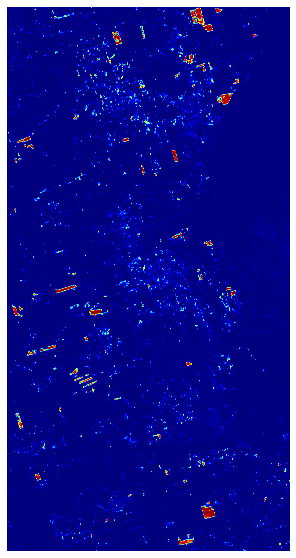

In [34]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [35]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [36]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54253101,)
(array([0, 1], dtype=uint8), array([53486282,   766819], dtype=int64))


In [37]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

91.03


In [38]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [39]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [40]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [42]:
'''
pred_var = predictive_variance(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive varance')
'''

"\npred_var = predictive_variance(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_var, ax, title = 'Uncertainty predictive varance')\n"

In [43]:
pred_entropy = predictive_entropy(prob_rec)




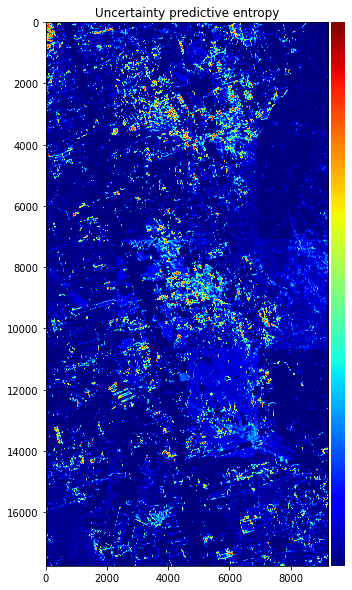

In [44]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [45]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

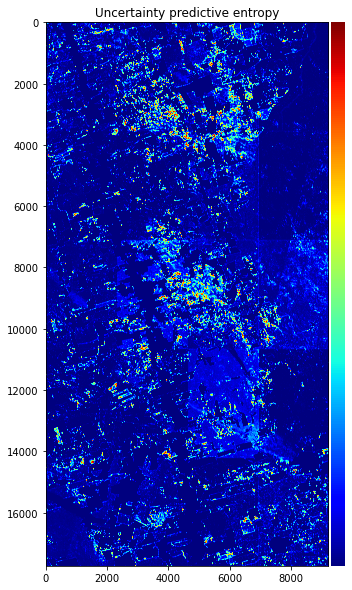

In [46]:
pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()
pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [47]:

'''
pred_entropy_single = single_experiment_entropy(prob_rec[0])

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\npred_entropy_single = single_experiment_entropy(prob_rec[0])\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [48]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


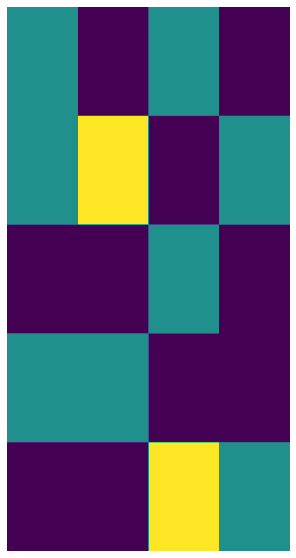

In [49]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [65]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [66]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1842066, 161273934], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1842066, 161273934], dtype=int64))

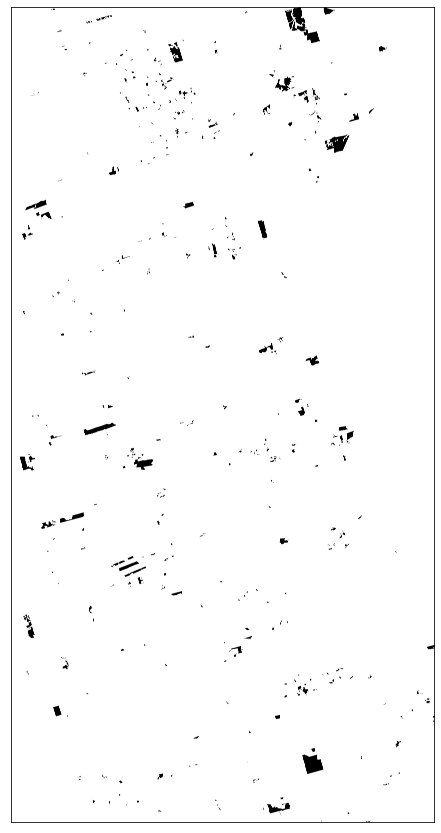

In [67]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [68]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9453222,)


(9453222,)

In [69]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [70]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.719922, F-Score=0.858


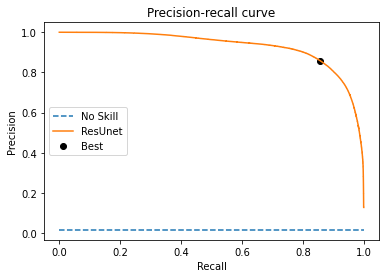

In [71]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [72]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
# threshold = 0.5
threshold = best_threshold
predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
(array([0., 1.]), array([161432120,   1683880], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


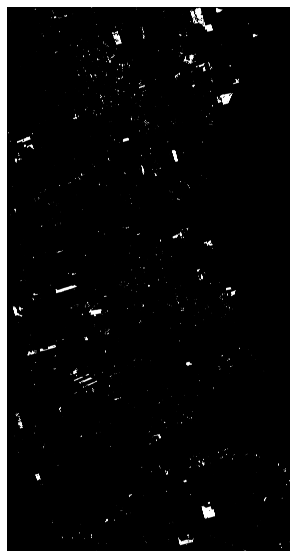

In [73]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [74]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [75]:
# mean_prob_unpad.shape

In [76]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [77]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [78]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [79]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [80]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [81]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)

        mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                mean_prob_test)*100, 2)

        ic(f1, precision, recall, mAP)

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54253101,)
ic| f1: 83.24, precision: 87.77, recall: 79.15, mAP: 91.03


In [82]:
ic(f1, precision, recall, mAP)

ic| f1: 83.24, precision: 87.77, recall: 79.15, mAP: 91.03


(83.24, 87.77, 79.15, 91.03)

### Metrics for validation set in forest/deforestation detection

In [83]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [84]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [85]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 85.79
    precision_val: 85.75
    recall_val: 85.82
    mAP_val: 92.94


(85.79, 85.75, 85.82, 92.94)

In [86]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.]), array([162515296,    600704], dtype=int64))


In [87]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.]), array([   379445, 162515296,    221259], dtype=int64))


(array([-1.,  0.,  1.]), array([   379445, 162515296,    221259], dtype=int64))

In [88]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [89]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

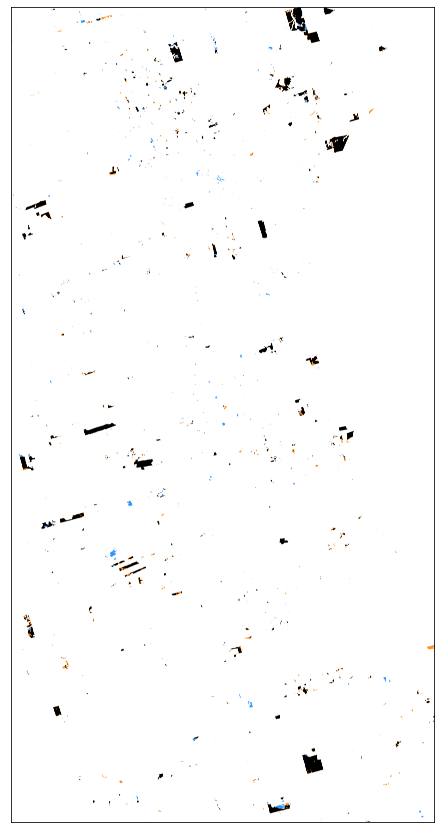

In [90]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


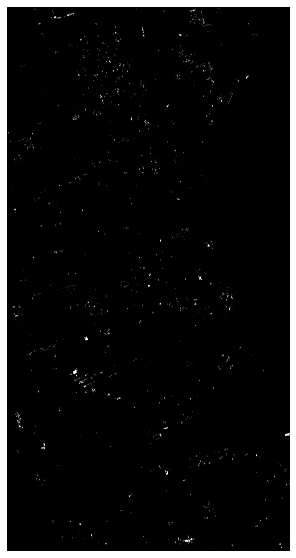

In [91]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [92]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [93]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54253101,)


(54253101,)

In [94]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [95]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  





ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [96]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [97]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    y_pred = pred_var_test
    y_pred_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    y_pred = MI_test
    y_pred_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    y_pred = pred_entropy_test
    y_pred_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    y_pred = pred_entropy_single_test
    y_pred_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [98]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, y_pred.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54253101,), y_pred.shape: (54253101,)
ic| roc_auc: 0.9432558702922682


0.9432558702922682

Best Threshold=0.036082, G-Mean=0.884


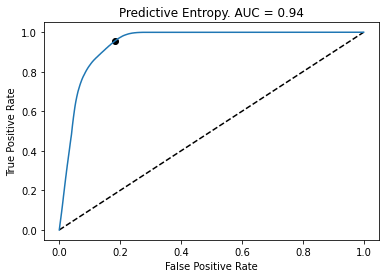

In [99]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [100]:
np.set_printoptions(suppress=False)
ic(best_threshold)
np.set_printoptions(suppress=True)


ic| best_threshold: 0.03608158155514845


In [101]:
# best_threshold = 0.262948
# best_threshold = 0.08329400420188904

In [102]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(y_pred)
y_pred_thresholded[y_pred >= best_threshold] = 1


In [103]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [104]:
if metrics_error_detection == True:

    ic(best_threshold)

In [105]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [106]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [107]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [108]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [109]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


## Get 2x2 forest/deforestation confusion matrices for correct and incorrect samples

In [110]:
if metrics_error_detection == True:

    # predicted_test is the prediction of no deforestation vs. deforestation
    # label_mask_current_deforestation_test
    # y_pred, y_pred_thresholded
    ic(np.unique(y_pred_thresholded, return_counts=True))
    ic(predicted_test.shape, y_pred_thresholded.shape, label_mask_current_deforestation_test.shape)

    predicted_test_classified_correct = predicted_test[y_pred_thresholded == 0]
    label_current_deforestation_test_classified_correct = label_mask_current_deforestation_test[y_pred_thresholded == 0]

    predicted_test_classified_incorrect = predicted_test[y_pred_thresholded == 1]
    label_current_deforestation_test_classified_incorrect = label_mask_current_deforestation_test[y_pred_thresholded == 1]

    ic(np.unique(predicted_test_classified_correct, return_counts=True))
    ic(np.unique(label_current_deforestation_test_classified_correct, return_counts=True))
    ic(np.unique(predicted_test_classified_incorrect, return_counts=True))
    ic(np.unique(label_current_deforestation_test_classified_incorrect, return_counts=True))

In [111]:
if metrics_error_detection == True:

    cm_correct = metrics.confusion_matrix(label_current_deforestation_test_classified_correct,
        predicted_test_classified_correct)
    ic(cm_correct)

In [112]:
if metrics_error_detection == True:

        _metrics.plotConfusionMatrix(cm_correct, 
                target_names = ['Forest', 'Deforestation'])
        plt.title('Classified as correct')
        plt.savefig(figures_path + title_name + ' confusion matrix correct.png', 
                dpi=200, bbox_inches='tight')

In [113]:
if metrics_error_detection == True:

    cm_incorrect = metrics.confusion_matrix(label_current_deforestation_test_classified_incorrect,
        predicted_test_classified_incorrect)
    ic(cm_incorrect)

In [114]:
if metrics_error_detection == True:

        _metrics.plotConfusionMatrix(cm_incorrect, 
                target_names = ['Forest', 'Deforestation'])
        plt.title('Classified as incorrect')
        plt.savefig(figures_path + title_name + ' confusion matrix incorrect.png', 
                dpi=200, bbox_inches='tight')

Get precision-recall threshold

In [115]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, y_pred_val, pos_label=pos_label)



In [116]:
ic(thresholds)

ic| thresholds: array([0.00893822, 0.00893824, 0.00893827, ..., 0.36787944, 0.36787944,
                       0.36787944])


array([0.00893822, 0.00893824, 0.00893827, ..., 0.36787944, 0.36787944,
       0.36787944])

In [117]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.201322, F-Score=0.158


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_18872\2212693297.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


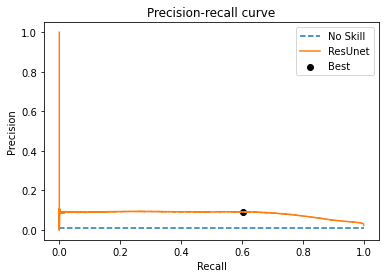

In [118]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [119]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [120]:
ic(np.min(y_pred), np.average(y_pred), np.max(y_pred))

ic| np.min(y_pred): 1.6140956450500463e-08
    np.average(y_pred): 0.03731400495295099
    np.max(y_pred): 0.3678794411707044


(1.6140956450500463e-08, 0.03731400495295099, 0.3678794411707044)

In [121]:
importlib.reload(_metrics)

threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metrics_values)



ic| y_pred.shape: (54253101,)
    label_mask_current_deforestation_test.shape: (54253101,)


threshold 0.01
(25357283,) (25357283,)
cm_correct [[25322422        2]
 [      97    34762]]
(28895818,) (28895818,)
cm_incorrect [[28079257    84601]
 [  159758   572202]]
[0.99994247 0.99721736 0.04533273 0.53261136 0.87119273 0.78173944]
threshold 0.015
(29356908,) (29356908,)
cm_correct [[29299710       30]
 [     141    57027]]
(24896193,) (24896193,)
cm_incorrect [[24101969    84573]
 [  159714   549937]]
[0.99947421 0.99753359 0.07436827 0.45888977 0.86671132 0.77494008]
threshold 0.025
(35118502,) (35118502,)
cm_correct [[34997452      157]
 [     265   120628]]
(19134599,) (19134599,)
cm_incorrect [[18404227    84446]
 [  159590   486336]]
[0.99870017 0.99780798 0.15730961 0.35269134 0.8520521  0.75292835]
threshold 0.05
(43621179,) (43621179,)
cm_correct [[43321336     1829]
 [     768   297246]]
(10631922,) (10631922,)
cm_incorrect [[10080343    82774]
 [  159087   309718]]
[0.99388448 0.99742294 0.38763515 0.19596893 0.78910653 0.66065422]
threshold 0.08
(47411378,) (474113

d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


[0.87766478 0.95869017 0.7915349  0.03057798        nan 0.        ]
threshold 0.27
(52824806,) (52824806,)
cm_correct [[52090300    84603]
 [   42939   606964]]
(1428295,) (1428295,)
cm_incorrect [[1311379       0]
 [ 116916       0]]
[0.87766478 0.93393014 0.7915349  0.02632651        nan 0.        ]
threshold 0.3


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


(53153427,) (53153427,)
cm_correct [[52393364    84603]
 [   68496   606964]]
(1099674,) (1099674,)
cm_incorrect [[1008315       0]
 [  91359       0]]
[0.87766478 0.89859355 0.7915349  0.02026933        nan 0.        ]
threshold 0.34


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


(53618832,) (53618832,)
cm_correct [[52821378    84603]
 [  105887   606964]]
(634269,) (634269,)
cm_incorrect [[580301      0]
 [ 53968      0]]
[0.87766478 0.85145984 0.7915349  0.01169093        nan 0.        ]
threshold 0.36


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


(53934218,) (53934218,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics_values: array([[0.99994247, 0.99721736, 0.04533273, 0.53261136, 0.87119273,
                            0.78173944],
                           [0.99947421, 0.99753359, 0.07436827, 0.45888977, 0.86671132,
                            0.77494008],
                           [0.99870017, 0.99780798, 0.15730961, 0.35269134, 0.8520521 ,
                            0.75292835],
                           [0.99388448, 0.99742294, 0.38763515, 0.19596893, 0.78910653,
                            0.66065422],
                           [0.98605212, 0.99599654, 0.54375544, 0.1261075 , 0.70709732,
                            0.54569893],
                           [0.9774865 , 0.99451071, 0.60578442, 0.09868219, 0.65839115,
                            0.47522087],
                           [0.95026954, 0.98894693, 0.69354698, 0.062171

cm_correct [[53110282    84603]
 [  132369   606964]]
(318883,) (318883,)
cm_incorrect [[291397      0]
 [ 27486      0]]
[0.87766478 0.8209616  0.7915349  0.00587769        nan 0.        ]


In [122]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(y_pred,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(y_pred,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [123]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [124]:
save_figures = True

In [125]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}



In [126]:
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [127]:
m['precision_H'] = np.nan_to_num(m['precision_H'], nan=0)

In [128]:
'''
m = {'precision_L': metrics[1:,0],
        'recall_L': metrics[1:,1],
        'recall_Ltotal': metrics[1:,2],
        'AA': metrics[1:,3],
        'precision_H': metrics[1:,4],
        'recall_H': metrics[1:,5]}

threshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
'''

"\nm = {'precision_L': metrics[1:,0],\n        'recall_L': metrics[1:,1],\n        'recall_Ltotal': metrics[1:,2],\n        'AA': metrics[1:,3],\n        'precision_H': metrics[1:,4],\n        'recall_H': metrics[1:,5]}\n\nthreshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\n"

In [129]:
'''
plt.plot(m['recall_L']*100, m['AA']*100)
plt.title('Recall vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, m['AA']*100)\nplt.title('Recall vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')\n"

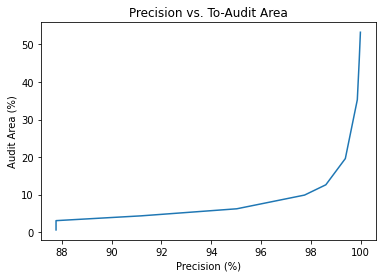

In [130]:
plt.plot(m['precision_L']*100, m['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')

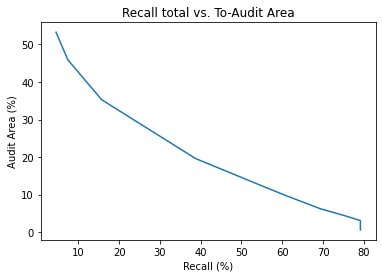

In [131]:
plt.plot(m['recall_Ltotal']*100, m['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')

In [132]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Recall vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Recall vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

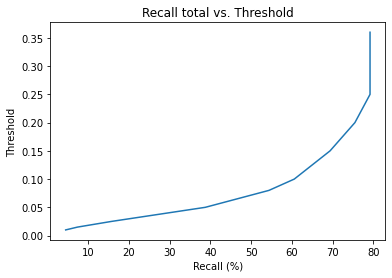

In [133]:
plt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')

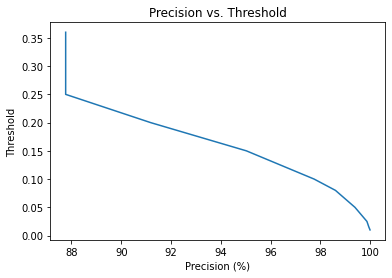

In [134]:
plt.plot(m['precision_L']*100, np.asarray(threshold_list))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')

In [135]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Audit area vs. Threshold')
plt.xlabel('Audit area (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Audit area vs. Threshold')\nplt.xlabel('Audit area (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

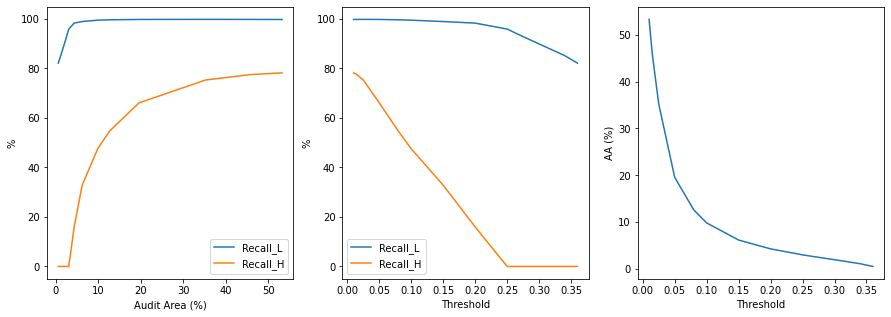

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax1.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(np.asarray(threshold_list), m['recall_L']*100, label="Recall_L")
ax2.plot(np.asarray(threshold_list), m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower left")
ax2.set_ylabel('%')
ax2.set_xlabel('Threshold')

ax3.plot(np.asarray(threshold_list), m['AA']*100, label="AA")
ax3.set_ylabel('AA (%)')
ax3.set_xlabel('Threshold')

if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')

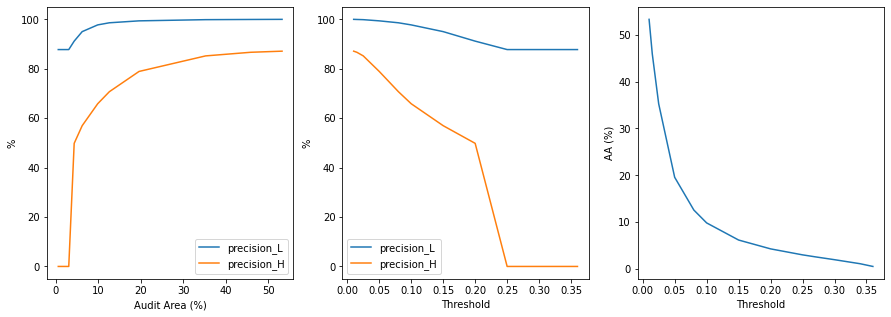

In [137]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(np.asarray(threshold_list), m['precision_L']*100, label="precision_L")
ax2.plot(np.asarray(threshold_list), m['precision_H']*100, label="precision_H")
ax2.legend(loc="lower left")
ax2.set_ylabel('%')
ax2.set_xlabel('Threshold')

ax3.plot(np.asarray(threshold_list), m['AA']*100, label="AA")
ax3.set_ylabel('AA (%)')
ax3.set_xlabel('Threshold')

if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')

In [138]:
epsilon = 1e-6
m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'] + epsilon)



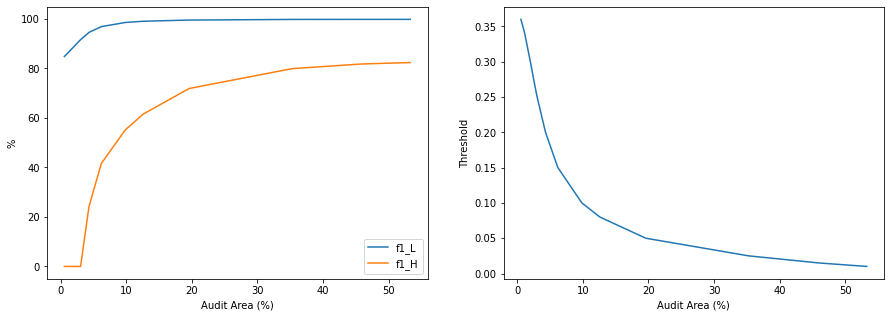

In [139]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['f1_L']*100, label="f1_L")
ax1.plot(m['AA']*100, m['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA.png', dpi=150, bbox_inches='tight')

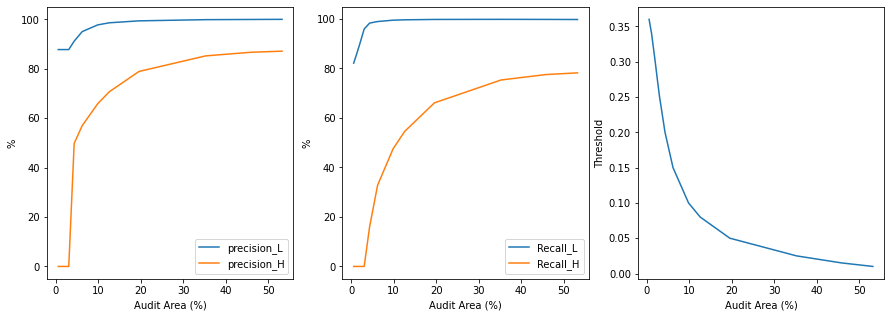

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

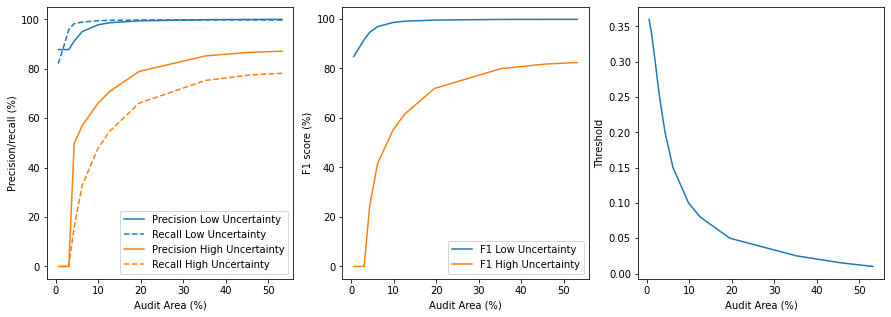

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')


ax2.plot(m['AA']*100, m['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [142]:


m

{'precision_L': array([0.99994247, 0.99947421, 0.99870017, 0.99388448, 0.98605212,
        0.9774865 , 0.95026954, 0.91179683, 0.87766478, 0.87766478,
        0.87766478, 0.87766478, 0.87766478]),
 'recall_L': array([0.99721736, 0.99753359, 0.99780798, 0.99742294, 0.99599654,
        0.99451071, 0.98894693, 0.98263636, 0.95869017, 0.93393014,
        0.89859355, 0.85145984, 0.8209616 ]),
 'recall_Ltotal': array([0.04533273, 0.07436827, 0.15730961, 0.38763515, 0.54375544,
        0.60578442, 0.69354698, 0.75446227, 0.7915349 , 0.7915349 ,
        0.7915349 , 0.7915349 , 0.7915349 ]),
 'AA': array([0.53261136, 0.45888977, 0.35269134, 0.19596893, 0.1261075 ,
        0.09868219, 0.06217121, 0.04334337, 0.03057798, 0.02632651,
        0.02026933, 0.01169093, 0.00587769]),
 'precision_H': array([0.87119273, 0.86671132, 0.8520521 , 0.78910653, 0.70709732,
        0.65839115, 0.56962323, 0.49816003, 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 'recall_H': array([0.781

In [143]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([9182054,  271168], dtype=int64))

In [144]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(y_pred_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(y_pred_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| y_pred_val.shape: (9453222,)
    label_mask_val_valid.shape: (9453222,)


threshold 0.015
(6727223,) (6727223,)
cm_correct [[6692471      22]
 [      0   34730]]
(2725999,) (2725999,)
cm_incorrect [[2450917   38644]
 [  38455  197983]]
[0.99936694 1.         0.12807558 0.28836718 0.83668812 0.83735694]
threshold 0.025
(7280065,) (7280065,)
cm_correct [[7194641     780]
 [      0   84644]]
(2173157,) (2173157,)
cm_incorrect [[1948747   37886]
 [  38455  148069]]
[0.99086908 1.         0.31214598 0.22988532 0.79626254 0.7938335 ]
threshold 0.05
(7975436,) (7975436,)
cm_correct [[7820754    6741]
 [     25  147916]]
(1477786,) (1477786,)
cm_incorrect [[1322634   31925]
 [  38430   84797]]
[0.95641322 0.99983101 0.54547734 0.15632617 0.72648687 0.68813653]
threshold 0.08
(8352874,) (8352874,)
cm_correct [[8162729   11164]
 [    146  178835]]
(1100348,) (1100348,)
cm_incorrect [[980659  27502]
 [ 38309  53878]]
[0.9412418  0.99918427 0.65949891 0.11639926 0.66205456 0.58444249]
threshold 0.1
(8508153,) (8508153,)
cm_correct [[8303298   13718]
 [    189  190948]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


cm_correct [[8845953   38666]
 [   8447  232713]]
(327443,) (327443,)
cm_incorrect [[297435      0]
 [ 30008      0]]
[0.85752029 0.96497346 0.85818754 0.03463824        nan 0.        ]
threshold 0.3
(9198535,) (9198535,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


cm_correct [[8912382   38666]
 [  14774  232713]]
(254687,) (254687,)
cm_incorrect [[231006      0]
 [ 23681      0]]
[0.85752029 0.94030394 0.85818754 0.02694182        nan 0.        ]
threshold 0.34
(9303043,) (9303043,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


cm_correct [[9007075   38666]
 [  24589  232713]]
(150179,) (150179,)
cm_incorrect [[136313      0]
 [ 13866      0]]
[0.85752029 0.90443526 0.85818754 0.01588654        nan 0.        ]
threshold 0.36
(9376786,) (9376786,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics_values_val: array([[0.99936694, 1.        , 0.12807558, 0.28836718, 0.83668812,
                                0.83735694],
                               [0.99086908, 1.        , 0.31214598, 0.22988532, 0.79626254,
                                0.7938335 ],
                               [0.95641322, 0.99983101, 0.54547734, 0.15632617, 0.72648687,
                                0.68813653],
                               [0.9412418 , 0.99918427, 0.65949891, 0.11639926, 0.66205456,
                                0.58444249],
                               [0.93297372, 0.99901118, 0.70416863, 0.09997322, 0.6260399 ,
                                0.52186028],
       

cm_correct [[9073759   38666]
 [  31648  232713]]
(76436,) (76436,)
cm_incorrect [[69629     0]
 [ 6807     0]]
[0.85752029 0.88028491 0.85818754 0.00808571        nan 0.        ]


In [145]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [146]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


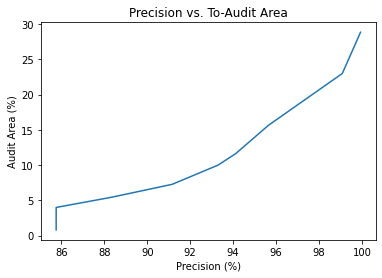

In [147]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

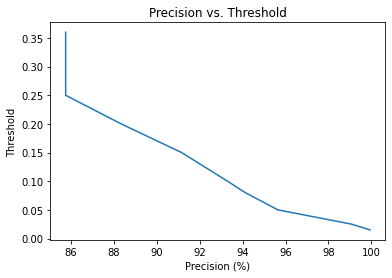

In [148]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

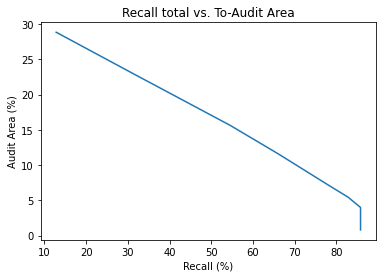

In [149]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

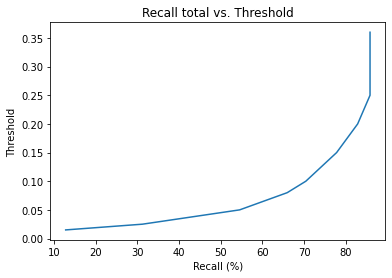

In [150]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

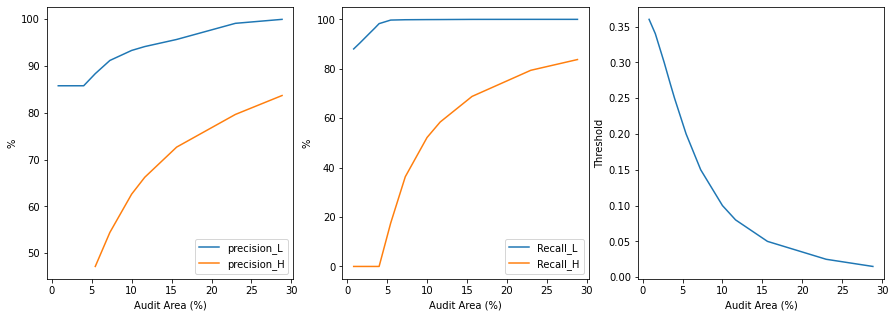

In [151]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

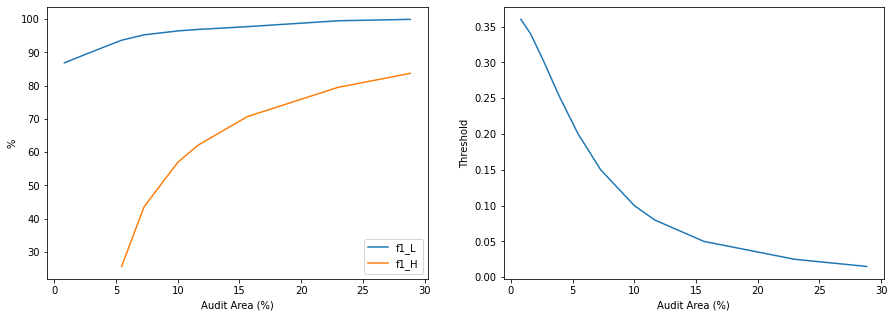

In [152]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

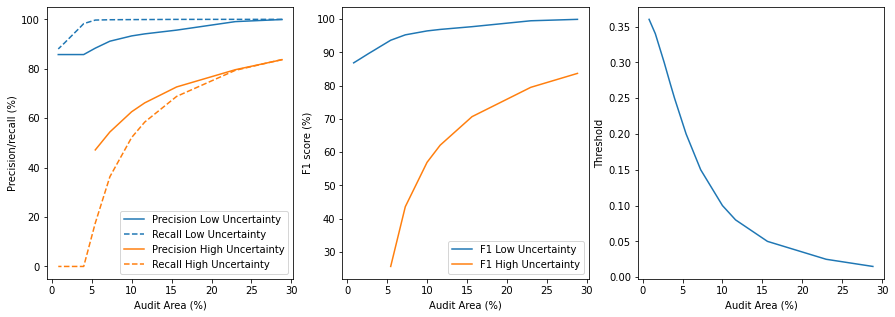

In [153]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')


ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')